In [1]:
from IPython.display import clear_output
import numpy as np
from framework.io_functions import Reader, Writer
from framework.pre_processing import PreProcessor
from framework.dfts import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from framework.ofunction import OFunction
from framework.utilities import real_to_complex, complex_to_real, find_pixel
from framework.priors import TSV, TV, L1, Chi2
from framework.optimizer import FISTA, ADMM, SDMM, GradientBasedMethod
from framework.analytical_functions import Gaussian
from framework.wavelet import Wavelet
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
from pandas.plotting import autocorrelation_plot
import itertools

In [2]:
# Read data reading
P = np.load("polarized_emission.npy")
sigma = np.load("sigmas.npy")
nu = np.load("freqs.npy")

In [3]:
t1 = c/nu
t1 = t1[::-1]

In [4]:
pre_proc = PreProcessor(freqs=nu)

W, K = pre_proc.calculate_W_K(sigma=sigma)
#W, K = pre_proc.calculate_W_K()
l2, l2_ref, phi, phi_r = pre_proc.calculate_phi(W, K, times=8, verbose=True)
n = len(phi)
m = len(l2)

Minimum Lambda-squared: 0.024 m^2
Maximum Lambda-squared: 0.088 m^2
delta Lambda-squared min: 2.464e-05 m^2
delta Lambda-squared max: 0.016 m^2
delta Lambda-squared mean: 1.175e-04 m^2
FWHM of the main peak of the RMTF: 54.084 rad/m^2
Maximum recovered width structure: 131.556 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 14737.933


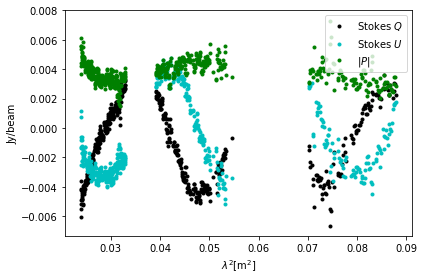

In [5]:
plt.plot(l2, P.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [6]:
nufft = NUFFT1D(W=W, lambda2=l2, lambda2_ref=l2_ref, phi=phi)

In [7]:
dft = DFT1D(W=W, lambda2=l2, lambda2_ref=l2_ref, phi=phi)

In [8]:
F_dirty = dft.backward(P)

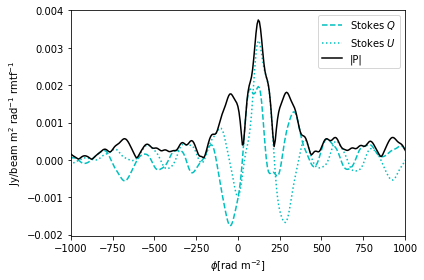

In [9]:
plt.plot(phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [10]:
P_back = nufft.forward_normalized(F_dirty)

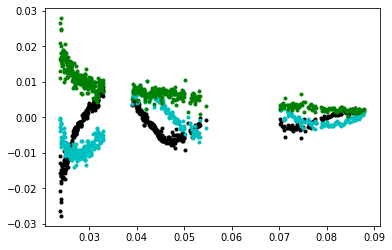

In [11]:
plt.plot(l2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_back), 'g.', label=r"$|P|$")

In [12]:
F_back = nufft.backward(P)

(-1000.0, 1000.0)

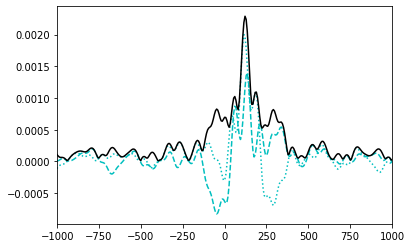

In [13]:
plt.plot(phi, F_back.real, 'c--', label=r"Real part")
plt.plot(phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000,1000])

In [14]:
idx_noise = np.where(np.abs(phi)>14000)
noise_F = np.std(0.5*(F_back[idx_noise].real + F_back[idx_noise].imag))
noise_F

1.126138e-05

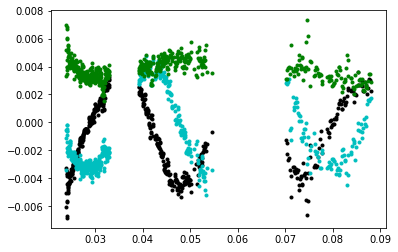

In [15]:
P_back = nufft.forward_normalized(F_back)
plt.plot(l2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_back), 'g.', label=r"$|P|$")

In [16]:
wav = Wavelet(wavelet_name="haar", mode="periodization")

In [17]:
lambda_l1 = np.sqrt(2 * len(P) + 4 * np.sqrt(len(P)))*noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(b=P, dft_obj=nufft, w=W, wavelet=wav)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

F_real = complex_to_real(F_back)
parameters = wav.decompose(F_real)
#parameters = F_real

In [18]:
opt = FISTA(i_guess=parameters, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()
#X = real_to_complex(X)
X = real_to_complex(wav.reconstruct(X))

Iterations set to 34
Iteration:  0  objective function value: 12316.99376


(-1000.0, 1000.0)

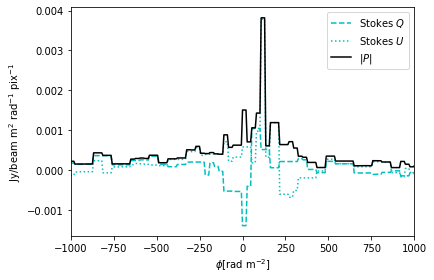

In [19]:
X_recon = X
plt.plot(phi, X_recon.real, 'c--', label=r"Stokes $Q$")
plt.plot(phi, X_recon.imag, 'c:', label=r"Stokes $U$")
plt.plot(phi, np.abs(X_recon), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

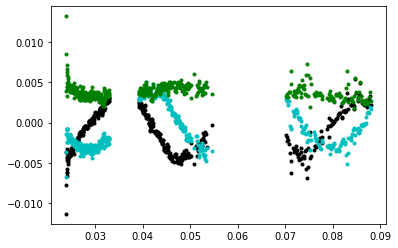

In [20]:
P_back = nufft.forward_normalized(X)
plt.plot(l2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_back), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

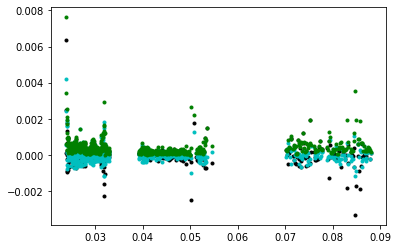

In [21]:
residual = P - P_back
plt.plot(l2, residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(residual), 'g.', label=r"$|P|$")

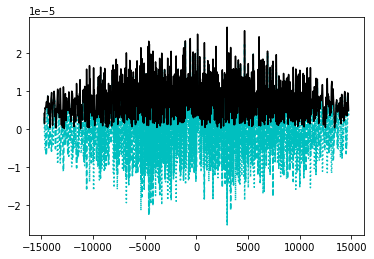

In [22]:
F_residual = nufft.backward(residual)
plt.plot(phi, F_residual.real, 'c--', label=r"Stokes $Q$")
plt.plot(phi, F_residual.imag, 'c:', label=r"Stokes $U$")
plt.plot(phi, np.abs(F_residual), 'k-', label=r"$|P|$")
#plt.xlim([-1000,1000])

In [23]:
idx = np.argmax(np.abs(X))
max_phi = phi[idx]

In [24]:
# Convolution
gauss_rmtf = Gaussian(x=phi, mu=0.0, fwhm=pre_proc.rmtf_fwhm)
gauss_rmtf_array = gauss_rmtf.run(normalized=True)
print(len(X)) # Even
F_conv = sci_signal.convolve(X, gauss_rmtf_array, mode='full', method='auto') 
F_restored = F_conv[n//2:(n//2)+n] + F_residual

4352


(-1000.0, 1000.0)

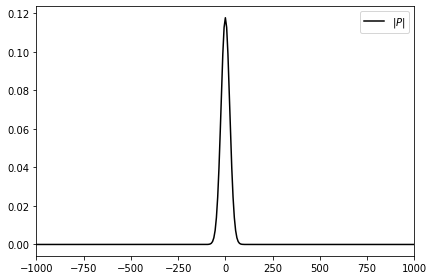

In [25]:
plt.plot(phi, gauss_rmtf_array, 'k-', label=r"$|P|$")
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

(-1000.0, 1000.0)

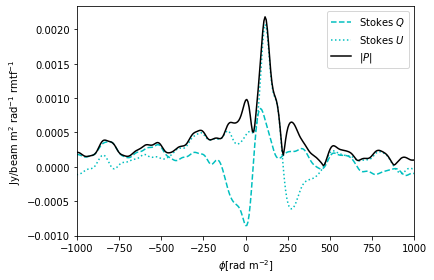

In [26]:
plt.plot(phi, F_restored.real, 'c--', label=r"Stokes $Q$")
plt.plot(phi, F_restored.imag, 'c:', label=r"Stokes $U$")
plt.plot(phi, np.abs(F_restored), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

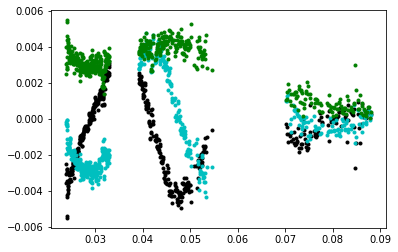

In [27]:
P_back = nufft.forward_normalized(F_restored)
plt.plot(l2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(l2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(l2, np.abs(P_back), 'g.', label=r"$|P|$")
#plt.ylim([-0.007,0.008])

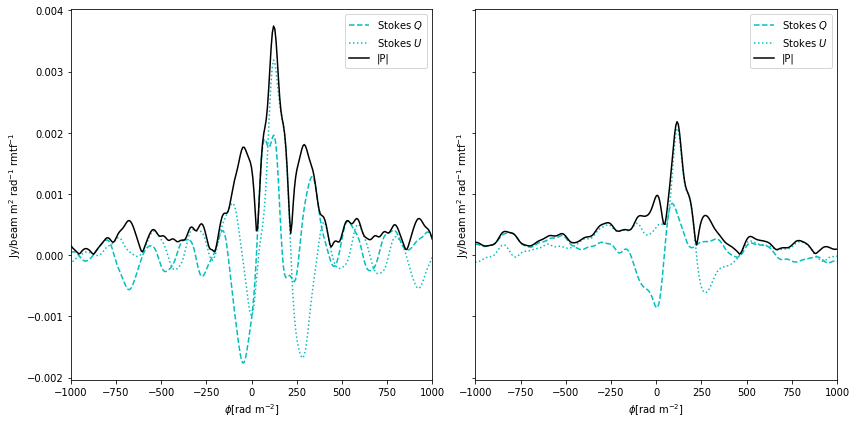

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), tight_layout=True, sharey=True, squeeze=True)
ax[0].plot(phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
ax[0].plot(phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
ax[0].plot(phi, np.abs(F_dirty), 'k-', label=r"|P|")
ax[0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[0].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[0].legend(loc='upper right')
ax[0].set_xlim([-1000,1000])
#plt.tight_layout()

ax[1].plot(phi, F_restored.real, 'c--', label=r"Stokes $Q$")
ax[1].plot(phi, F_restored.imag, 'c:', label=r"Stokes $U$")
ax[1].plot(phi, np.abs(F_restored), 'k-', label=r"|P|")
ax[1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1].set_ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1].legend(loc='upper right')
ax[1].set_xlim([-1000,1000])
plt.savefig('dirty-restored-comparison.png', dpi=100, bbox_inches='tight')

In [29]:
idx = np.argmax(np.abs(F_restored))
phi[idx]

115.14009983415738

In [30]:
idx = np.argmax(np.abs(F_dirty))
phi[idx]

121.91304688322546

In [31]:
import pywt
pywt.wavelist(kind="discrete")

['bior1.1',
 'bior1.3',
 'bior1.5',
 'bior2.2',
 'bior2.4',
 'bior2.6',
 'bior2.8',
 'bior3.1',
 'bior3.3',
 'bior3.5',
 'bior3.7',
 'bior3.9',
 'bior4.4',
 'bior5.5',
 'bior6.8',
 'coif1',
 'coif2',
 'coif3',
 'coif4',
 'coif5',
 'coif6',
 'coif7',
 'coif8',
 'coif9',
 'coif10',
 'coif11',
 'coif12',
 'coif13',
 'coif14',
 'coif15',
 'coif16',
 'coif17',
 'db1',
 'db2',
 'db3',
 'db4',
 'db5',
 'db6',
 'db7',
 'db8',
 'db9',
 'db10',
 'db11',
 'db12',
 'db13',
 'db14',
 'db15',
 'db16',
 'db17',
 'db18',
 'db19',
 'db20',
 'db21',
 'db22',
 'db23',
 'db24',
 'db25',
 'db26',
 'db27',
 'db28',
 'db29',
 'db30',
 'db31',
 'db32',
 'db33',
 'db34',
 'db35',
 'db36',
 'db37',
 'db38',
 'dmey',
 'haar',
 'rbio1.1',
 'rbio1.3',
 'rbio1.5',
 'rbio2.2',
 'rbio2.4',
 'rbio2.6',
 'rbio2.8',
 'rbio3.1',
 'rbio3.3',
 'rbio3.5',
 'rbio3.7',
 'rbio3.9',
 'rbio4.4',
 'rbio5.5',
 'rbio6.8',
 'sym2',
 'sym3',
 'sym4',
 'sym5',
 'sym6',
 'sym7',
 'sym8',
 'sym9',
 'sym10',
 'sym11',
 'sym12',
 'sym13',

In [32]:
pywt.wavelist(kind="continuous")

['cgau1',
 'cgau2',
 'cgau3',
 'cgau4',
 'cgau5',
 'cgau6',
 'cgau7',
 'cgau8',
 'cmor',
 'fbsp',
 'gaus1',
 'gaus2',
 'gaus3',
 'gaus4',
 'gaus5',
 'gaus6',
 'gaus7',
 'gaus8',
 'mexh',
 'morl',
 'shan']